In [1]:
import os

import torch.nn as nn
import torch.nn.functional as F

import torchvision

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.utils import make_grid
from torchvision.io import decode_image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

#### Making the data smaller 256x256 resolution

In [2]:
for i in glob.glob('datasethome/**/*.jpg',recursive=True):
    img= Image.open(i)
    img=img.resize((256,256))
    pth= '/'.join(('small'+i).split('/')[:-1])
    os.makedirs(pth,exist_ok=True)
    img.save('small'+i,format='JPEG')

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

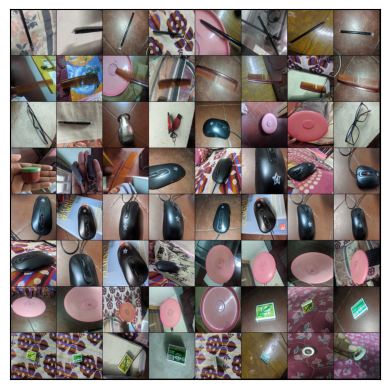

In [4]:
tmplist=[]
for i in glob.glob('smalldatasethome/**/*.jpg',recursive=True):
    tmp=decode_image(i)
    if tmp.data.shape==(3,256,256):
        tmplist.append(tmp)
    
    
    if len(tmplist)>63:break
grid = make_grid(tmplist)
show(grid)

Ok, first load the labels, in the folder name we keep the target label

It is a simple classification task, with categories like mouse,pendrive, pen,... it has 10 classes. 

#### Training

In [5]:
from torchvision.models import squeezenet1_0,SqueezeNet1_0_Weights

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [i for i in os.listdir(root_dir) if i[-4:]!='.mp4' and 'test' not in i]
        self.file_paths = []
        self.labels = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                # ignoring everything other than images
                if filename[-4:]!= '.jpg': continue
                file_path = os.path.join(class_dir, filename)
                self.file_paths.append(file_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

root_dir = 'smalldatasethome'
transform = SqueezeNet1_0_Weights.DEFAULT.transforms()
dataset = ImageDataset(root_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True,)

training a model from scratch for this data looks too much, lets use a pretrained model, and then fine tune it to our classes

In [6]:
model= squeezenet1_0(weights=SqueezeNet1_0_Weights.IMAGENET1K_V1)

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
model.classifier[1]=nn.Conv2d(512,10,kernel_size=1,stride=1)
model.num_classes= 10

In [9]:
for name,wt in model.named_parameters():
    if 'classifier' not in name and '12' not in name:
        wt.requires_grad=False
    else: 
        print(name,wt.numel())

features.12.squeeze.weight 32768
features.12.squeeze.bias 64
features.12.expand1x1.weight 16384
features.12.expand1x1.bias 256
features.12.expand3x3.weight 147456
features.12.expand3x3.bias 256
classifier.1.weight 5120
classifier.1.bias 10


In [10]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        #for i_ in model.parameters():
            #if i_.grad is not None:print(i_.data.norm()/i_.grad.norm())
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
        
        if i==5:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 2.2731
Epoch [2/10], Loss: 2.1009
Epoch [3/10], Loss: 2.0339
Epoch [4/10], Loss: 1.4660
Epoch [5/10], Loss: 1.3292
Epoch [6/10], Loss: 0.9810
Epoch [7/10], Loss: 1.2350
Epoch [8/10], Loss: 0.6276
Epoch [9/10], Loss: 0.5533
Epoch [10/10], Loss: 0.2374


##### Interesting bit
Tried training with as little number of params as possible this backfired, as only training last layer was not possible.When dug into the issue i found that gradients(norm) is very high compared to their tensors, as high as 100 times.
Normally a heuristic is that gradients should be around 100 times smaller than their tensors. It was exactly the opposite in our case.
So,last but one layer is also made trainable, this did set things right for the time being, making total trainable params to be around 200,000.

#### Gradcam visualization

In [11]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [12]:
gradcam_pp=GradCAMpp.from_config(**dict(model_type='squeezenet', arch=model, layer_name='features_12_expand3x3_activation'))

In [13]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
reverse_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std])

/home/manoj/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/home/manoj/miniconda3/envs/pytorch/lib/python3.9/site-packages/gradcam/gradcam.py:147: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
/tmp/ipykernel_61780/2312896255.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

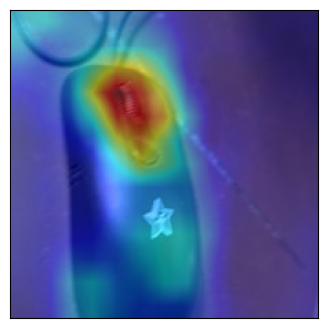

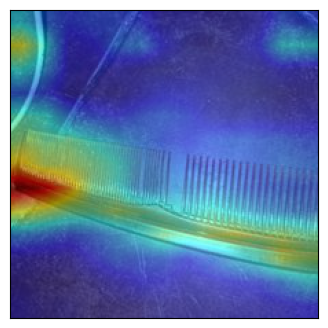

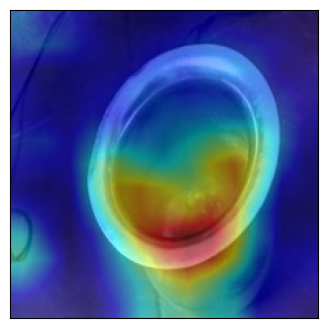

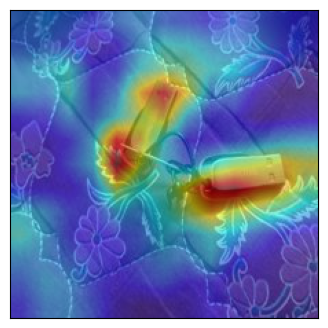

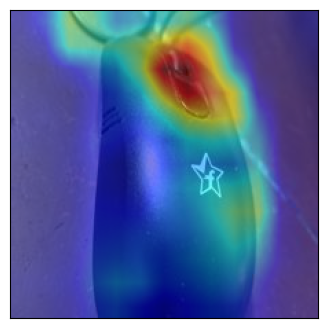

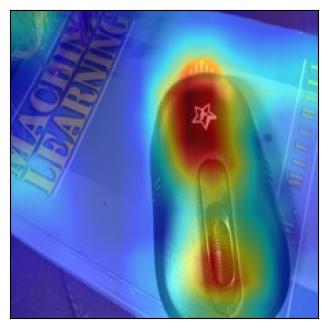

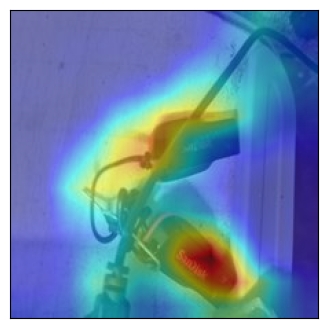

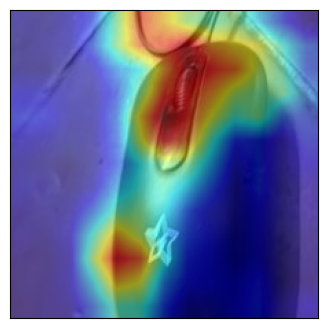

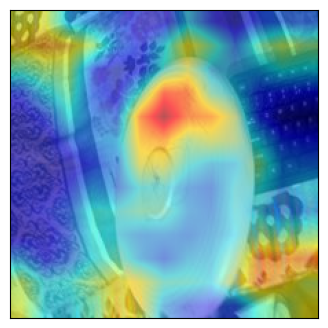

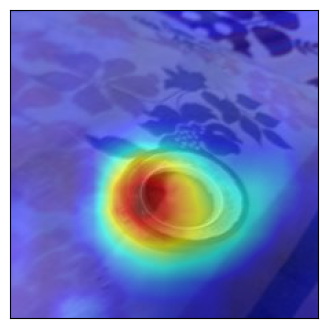

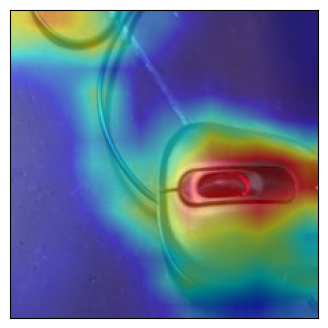

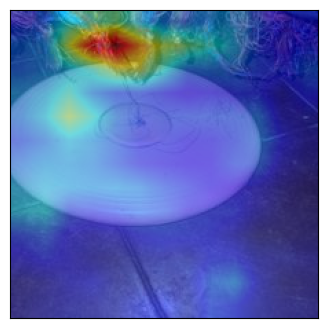

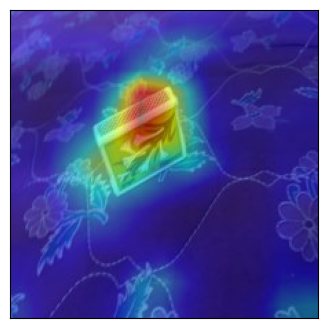

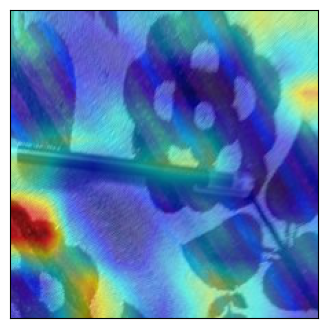

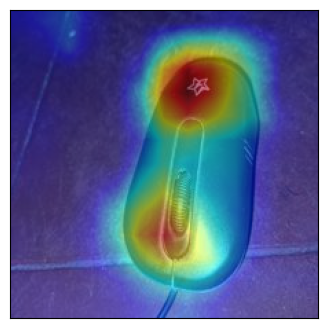

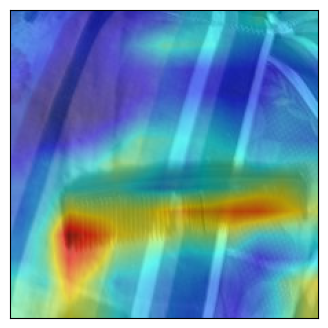

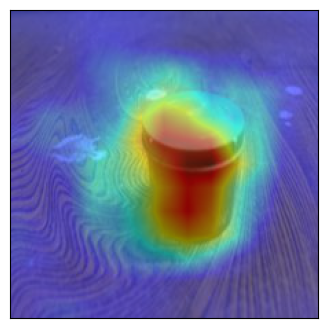

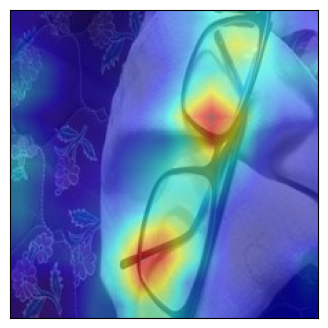

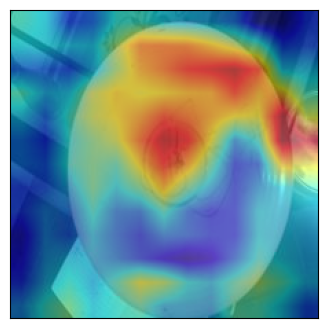

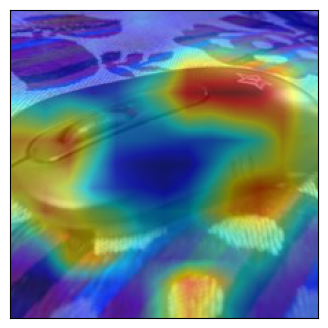

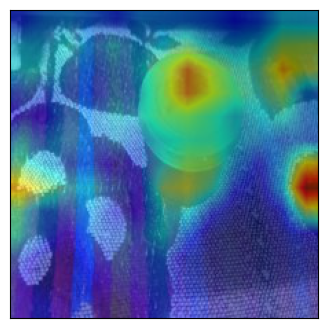

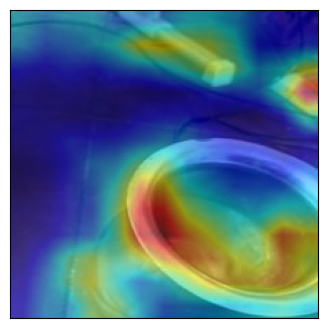

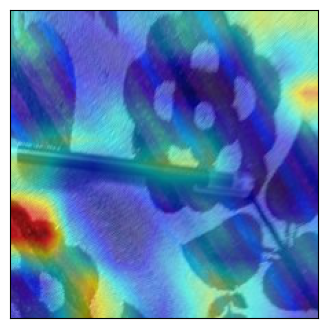

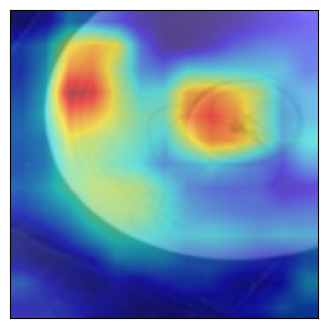

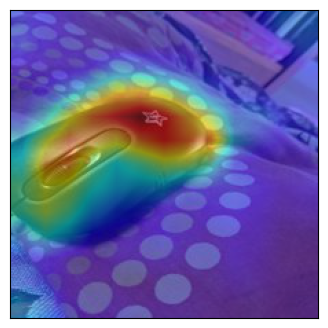

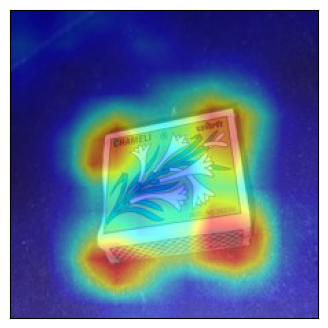

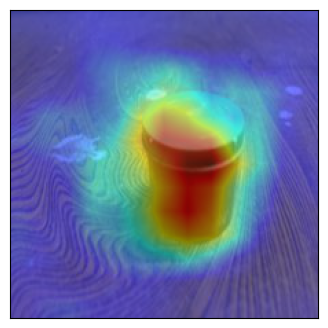

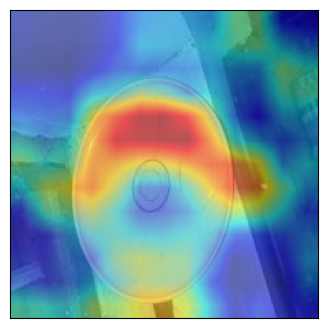

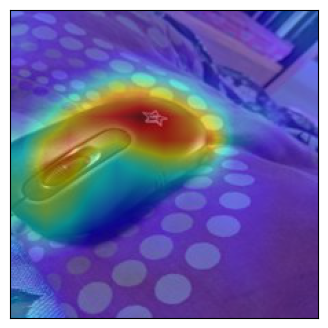

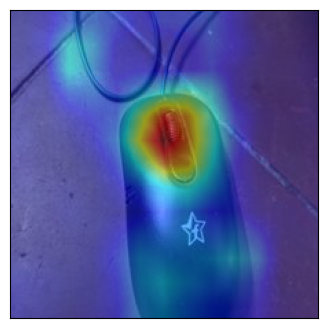

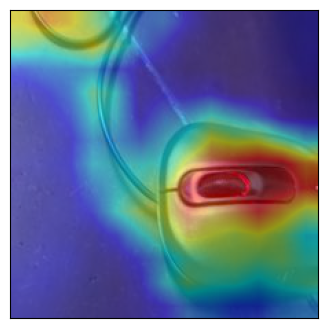

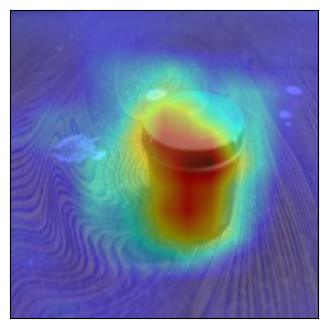

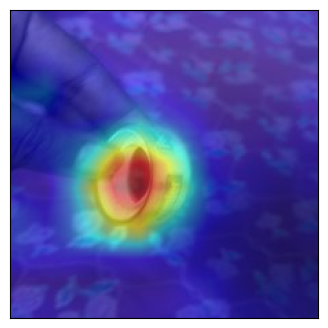

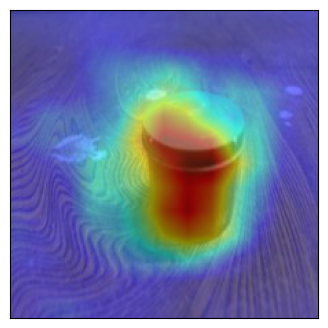

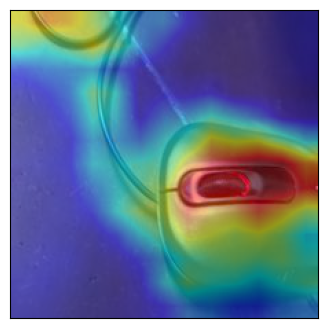

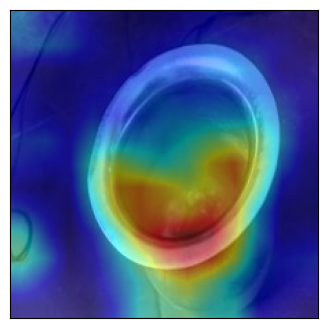

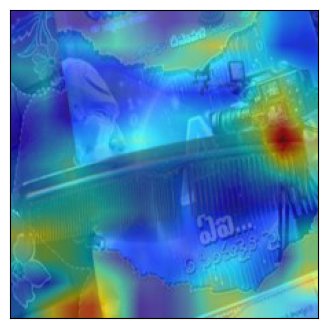

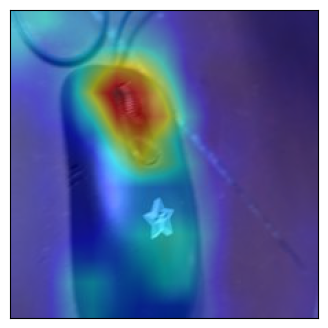

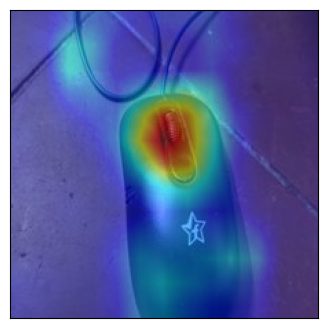

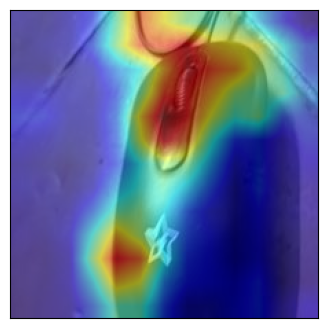

In [14]:
for i in np.random.randint(0,90,40):    
    mask_pp, _ = gradcam_pp(dataset[i][0].unsqueeze(0))
    heatmap_pp, result_pp = visualize_cam(mask_pp, reverse_normalize(dataset[i][0].unsqueeze(0)))
    
    image_numpy = result_pp.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.figure(figsize=(4,4))
    plt.imshow(image_numpy)
    plt.axis('off')

The gradcam images look fine, the model is looking at places it should ideally be looking at.